In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Data Preprocessing

In [2]:
# import raw data
df_raw = pd.read_csv('./data/bj_s_train.csv', usecols=['lat','lng','time','flow','dm'])
print('Area:', int(df_raw['lat'].unique().shape[0]) * int(df_raw['lng'].unique().shape[0]), 'blocks')
print('Period:', int(df_raw['time'].unique().shape[0]/24), 'days')

Area: 25 blocks
Period: 28 days


In [3]:
data_wide = df_raw.pivot_table(index=['lat','lng'], columns='time', values=['dm'], fill_value=0).reset_index()
data_wide.shape

(25, 674)

In [4]:
img1 = np.reshape(data_wide.iloc[:,2].values,(5,5)).astype(np.float32)
img1

array([[  0.,   0.,   2.,   0.,   0.],
       [  1.,   6.,   0.,   0.,  11.],
       [  3.,   0.,   1.,   3.,  28.],
       [  0.,   0.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   0.,   0.]], dtype=float32)

In [5]:
n_Ts = data_wide.shape[1]-2           # number of timesteps
imgs = np.array([np.reshape(data_wide.iloc[:,2+i].values, (5,5)).astype(np.float32) for i in range(n_Ts)])

In [6]:
x_input  = imgs[:-1, :, :]
y_target = imgs[1:, :, :]
y_target = y_target.reshape(y_target.shape[0],y_target.shape[1] * y_target.shape[2])

# Define The 3D-CNN Model Structure

In [7]:
def weight_var(name, shape, stddev=0.1, mean= 0.0):
    wt = tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                         initializer=tf.truncated_normal_initializer(mean=mean, stddev=stddev))
    return wt

def bias_var(name, shape, const=0.01):
    bias = tf.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=tf.constant_initializer(const))
    return bias

def conv2d(input_data, wt):
    # input = [batch, in_height, in_width, in_channels]
    conv = tf.nn.conv2d(input_data, wt, strides=[1, 1, 1, 1], padding='SAME')
    return conv
    
def max_pool2d(input_data, h=2, w=2):
    max_pool = tf.nn.max_pool(input_data, ksize=[1, h, w, 1],
                               strides=[1, 1, 1, 1], padding='SAME')
    return max_pool


In [9]:
# params
# fixed image size
IMG_WIDTH = 5
IMG_HEIGHT = 5

# timestep to lookback
depth = 24

num_channels = 1
conv1_features = 1

max_pool_strides = {'l1': [1,1], 'l2':[1,1]} 
fc_layer_size = [64,32]

batch_size = 10
epoches = 10
eval_every = 50

In [10]:
# define the structure of neural network 

def conv_net(x_input):

    # Convoluational Layer 1
    with tf.variable_scope('conv1'):

        # convolutional layer 1 variables
        conv1_weight = weight_var('conv1_weight', [2, 2, num_channels, conv1_features], 0.1)
        conv1_bias = bias_var('conv1_bias', [conv1_features], 0.05)
        
        conv1 = conv2d(x_input, conv1_weight)
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
        max_pool1 = max_pool2d(relu1)

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool1.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool1, [-1, final_shape])

    # FC Layer 1
    with tf.variable_scope('fc1'):
        fc1_weight = weight_var('fc1_weight', [final_shape, fc_layer_size[0]], stddev=0.1)
        fc1_bias = bias_var('fc1_bias', [fc_layer_size[0]], 0.05)
        
        fc1 = tf.nn.relu(tf.add(tf.matmul(flat_output, fc1_weight), fc1_bias))

    # FC Layer 2
    with tf.variable_scope('fc2'):
        fc2_weight = weight_var('fc2_weight', [fc_layer_size[0], fc_layer_size[1]], stddev=0.1)
        fc2_bias = bias_var('fc2_bias', [fc_layer_size[1]], 0.05)
        
        fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, fc2_weight), fc2_bias))

    # Final output
    with tf.variable_scope('output'):
        # Output variables
        output_weight = weight_var('output_weight', [fc_layer_size[1], IMG_WIDTH * IMG_HEIGHT], stddev=0.1)
        output_bias = bias_var('output_bias', [IMG_WIDTH * IMG_HEIGHT], const=0.1)
        
        model_output = tf.add(tf.matmul(fc2, output_weight), output_bias)
    
    return model_output



In [11]:
def loss(output, target):
    # Training loss function: RMSE
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(output, target))), name = 'RMSE')
    
    return loss

def train_step(loss):

    start_rate = 1e-4
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Create an optimizer
    learning_rate = tf.train.exponential_decay(start_rate, global_step, 100, 0.95, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(loss, global_step=global_step)
    
    return train_step


# Model Training 

In [12]:
# Training Process
with tf.Graph().as_default():

    # Declare model placeholders
    X = tf.placeholder(tf.float32, shape=[None, IMG_WIDTH, IMG_HEIGHT, num_channels])
    Y = tf.placeholder(tf.float32, shape=[None, IMG_WIDTH * IMG_HEIGHT * num_channels])
    
    model_output = conv_net(X)

    #pred_batch = tf.nn.relu(model_output_batch)
    #pred = tf.nn.relu(model_output)

    loss = loss(model_output, Y)
    train_step = train_step(loss)

    # Start training loop
    train_loss = []

    with tf.Session() as sess: 
        
        init = tf.global_variables_initializer()
        sess.run(init)  

        for i in range(1000):
            # random select a batch of training samples 
            rand_index = np.random.choice(len(x_input), size=batch_size)
            batch_x = x_input[rand_index]
            batch_x = np.expand_dims(batch_x, 3)
            batch_y = y_target[rand_index]
            train_dict = {X: batch_x, Y: batch_y}


            sess.run(train_step, feed_dict=train_dict)
            temp_train_loss = sess.run([loss], feed_dict=train_dict)

            # Print training progress every 50 times
            if (i+1) % eval_every == 0:
                # Record and print results
                train_loss.append(temp_train_loss)
                print('Epoch # {0}. Train Loss: {1}.'.format(str(i+1), temp_train_loss[0]))

        
        test_dict = {X: np.expand_dims(x_input, 3)}
        preds = sess.run([model_output], feed_dict=test_dict)

        
        # save the trained model
        #saver = tf.train.Saver()
        #saver_path = saver.save(sess, "./3dcnn_model/model.ckpt")
        #saver.restore(sess, ckpt.model_checkpoint_path)

Epoch # 50. Train Loss: 16.601045608520508.
Epoch # 100. Train Loss: 22.496566772460938.
Epoch # 150. Train Loss: 8.663260459899902.
Epoch # 200. Train Loss: 9.983813285827637.
Epoch # 250. Train Loss: 6.939085483551025.
Epoch # 300. Train Loss: 14.609421730041504.
Epoch # 350. Train Loss: 7.583980560302734.
Epoch # 400. Train Loss: 10.685274124145508.
Epoch # 450. Train Loss: 9.09801197052002.
Epoch # 500. Train Loss: 10.197415351867676.
Epoch # 550. Train Loss: 4.365485668182373.
Epoch # 600. Train Loss: 14.945943832397461.
Epoch # 650. Train Loss: 3.5708227157592773.
Epoch # 700. Train Loss: 7.176253795623779.
Epoch # 750. Train Loss: 5.214826583862305.
Epoch # 800. Train Loss: 2.8340625762939453.
Epoch # 850. Train Loss: 3.974827289581299.
Epoch # 900. Train Loss: 13.092693328857422.
Epoch # 950. Train Loss: 2.95294451713562.
Epoch # 1000. Train Loss: 5.124130725860596.


# Evaluation 

In [13]:
def drawAllPred(pred, tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()

In [14]:
def drawplot(tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    #plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()

In [15]:
def drawPredEveryLoc(pred, tgt):
    plt.figure(figsize=(40,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.plot(tgt[:,i], color='mediumpurple',linewidth=1, marker='')
        plt.plot(pred[:,i], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.show()
    plt.close()

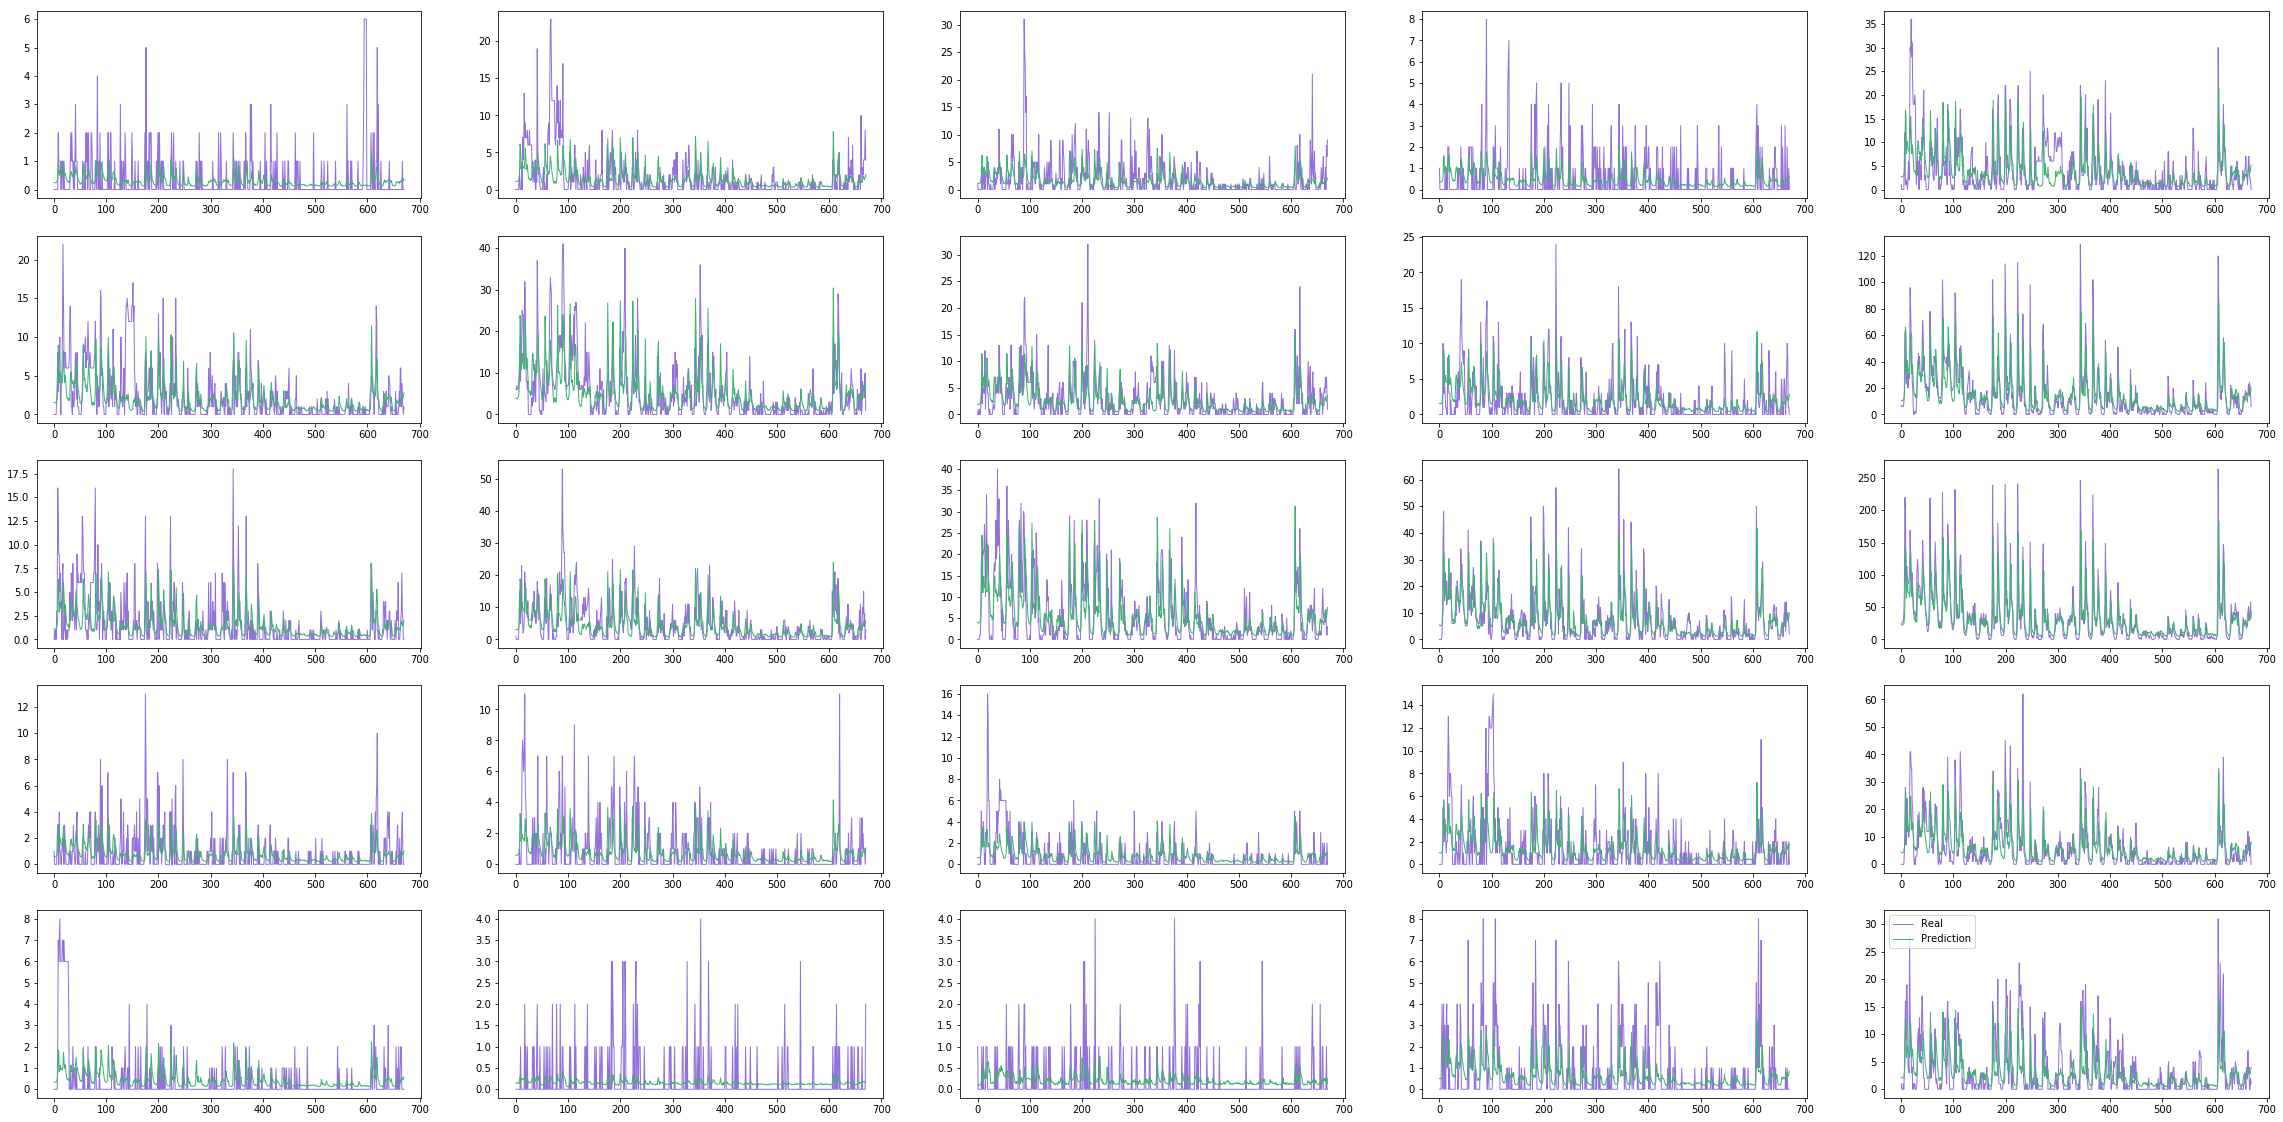

In [16]:
drawPredEveryLoc(preds[0], y_target)